<img width='600px' align='left' src='mfigs/cooking_header.pdf'>

In this lab, we will train SVMs to predict the category of a dish's cuisine given a list of its ingredients. This was a challenge hosted by Kaggle, the well known platform for data scientists and machine learners, owned by Google.  

https://www.kaggle.com/c/whats-cooking

## Data

The data for this challenge was provided by Yummly, a mobile app and website that provides personalized recipe recommendations. You should find a copy of the dataset together with this notebook (train_bss.json) that you can use for training and model selection purposes. Your final model will be evaluated using a different (secret) dataset. 


## Tools

For this activity we will use sklearn, a very complete library for machine learning in Python.  






Please refer to http://scikit-learn.org/stable/ for help regarding installation and usage.

## Problem & Dataset

For this experiment we will use a toy dataset. We will simulate the first class from a gaussian with center $(2,2)$ (positive class) and the second class from a gaussian with center $(-2,-2)$. To obtain a slightly more "realistic" and challeging problem, we will add $20\%$ spuriuous points to the first class. This data is spuriuous in the sense that this is present in the training set but wont be present in the test set, i.e., it is not representative of the data distribution. This data will be simulated from a gaussian correctly centered, but with larger variance. A similar problem can be obtained using the parameter _noise_ of the utility function 

sklearn.datasets.make_classification

in the scikit-learn library.

## Model 

Recall the soft-margin formulation is:

\begin{align}
\underset{{w},b,\xi}{\mbox{min}} & \ \frac{1}{2} \, \|w\|^2 + C \cdot \sum\nolimits_\ell \xi_\ell\\
\mbox{s.t.} & \ y^{(\ell)}(w^Tx^{(\ell)} + b) \geq 1 - \xi_\ell \, \forall \ell \notag\\
& \ \xi_\ell \geq 0 \, \forall \ell \notag
\end{align}

The classifier (decision function for new cases) takes the form
\begin{align}
f(x) &= \mbox{sign}\left(w^Tx +b \right)
\end{align}


In [2]:
from IPython.display import HTML, display

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)

    display(HTML('<img src onerror="{}">'.format(script)))

## Experience

### 1 Load, Explore and Prepare the Data 

We start by loading the data. Check that both sets (train & test) are in the right folder.

In [26]:
set_background('honeydew')

import numpy as np
import random

import json
def read_data(path):
    return json.load(open(path)) 

train_data = read_data('data/train_bss.json')
test_data = read_data('data/test_bss.json')

print("Number of training examples: %d"%len(train_data))
print("Number of test examples: %d"%len(test_data))

ntrain = len(train_data)
ntest = len(test_data)

### Explore the Structure of the Datasets
idx = random.randint(0, ntrain)
instance = train_data[idx] #Take the first training example
#print(type(instance)) #Discover this is a dictionary
keys = [key.encode("utf-8") for key in instance.keys()] #Collect all the Keys
print("Keys: %s"%str(keys))

print(" ")
print("Choosing a ramdom example ... \n")
print("ID & class: %s, %s"%(instance['id'],instance['cuisine']))
ingredients = ','.join(instance['ingredients'])
print(" ")
print("Ingredients: %s\n"% ingredients)

labels_train = [instance['cuisine'].encode("utf-8") for instance in train_data]
print("Classes in the TRAIN set: "+','.join(np.unique(labels_train))+"\n")
print("Number of Classes in the TRAIN set: %d\n"%len(np.unique(labels_train)))

labels_test = [instance['cuisine'].encode("utf-8") for instance in test_data]
print("Classes in the TEST set: "+','.join(np.unique(labels_test))+"\n")
print("Number of Classes in the TEST set: %d\n"%len(np.unique(labels_test)))




Number of training examples: 31820
Number of test examples: 7954
Keys: ['cuisine', 'id', 'ingredients']
 
Choosing a ramdom example ... 

ID & class: 36475, italian
 
Ingredients: ground black pepper,varnish clams,red chili peppers,shallots,dried oregano,dry white wine,spaghetti,olive oil,flat leaf parsley,chopped garlic

Classes in the TRAIN set: brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese

Number of Classes in the TRAIN set: 20

Classes in the TEST set: brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese

Number of Classes in the TEST set: 20



### 2 Represent the Data 

Now we need to properly represent the data.

First the train data 

In [37]:
texts_train = [' '.join(instance['ingredients']).lower() for instance in train_data]
labels_train = [instance['cuisine'].encode("utf-8") for instance in train_data]

from sklearn.feature_extraction.text import CountVectorizer

TF = CountVectorizer()
vocabulary = None

def represent_my_texts(texts, set_type):
    if set_type == 'train':
        X = TF.fit_transform(texts)
    else:
        X = TF.transform(texts)
    return X.astype('float16')

X_train = represent_my_texts(texts_train,'train')
print(X_train.shape)
 
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y_train = lb.fit_transform(labels_train)
print(np.unique(y_train))
print(len(y_train))
print(lb.inverse_transform(9)) #who is class 9?

(31820, 2881)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
31820
italian


In [ ]:
Now the test data

In [38]:
texts_test = [' '.join(instance['ingredients']).lower() for instance in test_data]
labels_test = [instance['cuisine'].encode("utf-8") for instance in test_data]

X_test = represent_my_texts(texts_test,'test')
print(X_test.shape)
y_test = lb.fit_transform(labels_test)
print(len(y_test))

(7954, 2881)
7954


In [41]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

svm = SVC(C=100, # penalty parameter
                 kernel='rbf', # kernel type, rbf working fine here
                 degree=3, # default value
                 gamma=1, # kernel coefficient
                 coef0=1, # change to 1 from default value of 0.0
                 shrinking=True, # using shrinking heuristics
                 tol=0.001, # stopping criterion tolerance 
                 probability=False, # no need to enable probability estimates
                 cache_size=200, # 200 MB cache size
                 class_weight=None, # all classes are treated equally 
                 verbose=False, # print the logs 
                 max_iter=-1, # no limit, let it run
                 decision_function_shape=None, # will use one vs rest explicitly 
                 random_state=None)

model = OneVsRestClassifier(svm, n_jobs=1)

model.fit(X_train, y_train)


KeyboardInterrupt: 

### 3. Computing the Margin 

Now, we will visualize the margin corresponding to our SVM. Recall that, in the hard-margin case, the margin $\rho$ is the distance of the hyperplane to the closest point in the dataset. In the soft-margin case and thanks to the slack variables $\xi_\ell$, we "ignore" some points in the computation of the margin. So, we need to consider only the points for which $\xi_\ell=0$. From optimization theory (KKT conditions), we known that, for these points, $y^{(\ell)}(w^Tx^{(\ell)} + b) \geq 1$. So, the closest point has to satisfy $y^{(\ell)}(w^Tx^{(\ell)} + b) = 1$. Since the distance of this point to the hyperplane is $\rho^{(\ell)} = (y^{(\ell)}(w^Tx^{(\ell)} + b))/\|w\|$, we get 
$$\rho=\frac{1}{\|w\|}$$. 

Using a bit of geometry, we can now visualize the margin of the SVM. Can you identify the support vectors?  

In [6]:
norm_w = np.sqrt(w[0]**2+w[1]**2)
   
margin = 1 / norm_w
print("Margin: %f"%margin)
cos_alpha = w[1]/norm_w
margin_y = margin/cos_alpha
print("Margin_y: %f"%margin_y)

Margin: 0.723006
Margin_y: 1.060932


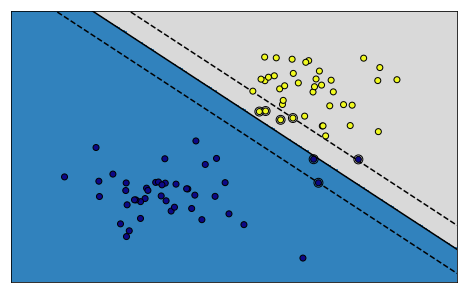

In [7]:

yy_down = yy - margin_y
yy_up = yy + margin_y

plt.figure(1, figsize=(8, 5))
plt.clf()
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

my_svm = clf
plt.scatter(my_svm.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.plasma,edgecolors='k')

plt.axis('tight')
x_min = -6; x_max = 6; y_min = -6; y_max = 6

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(XX, YY, Z, cmap=plt.cm.tab20c)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())
plt.show()


### 4 Geometrical Effect of C

We all the pieces required to analyze the effect of the soft-margin formulation and specifically parameter $C$ on the decision boundary. Compute the SVM using different values of $C$ and plot the decision boundary. What do you observe? For each case, compute the margin and the fraction of "ignored points". What can you conclude?


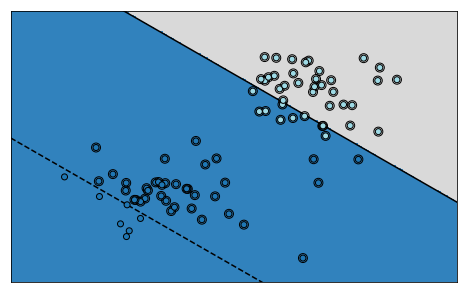

Margin with C=0.000750 is 6.166692. Misclassified points=89.772727%


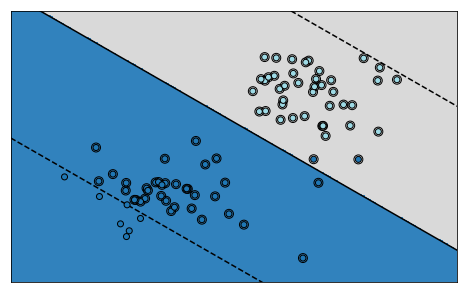

Margin with C=0.001000 is 4.625019. Misclassified points=89.772727%


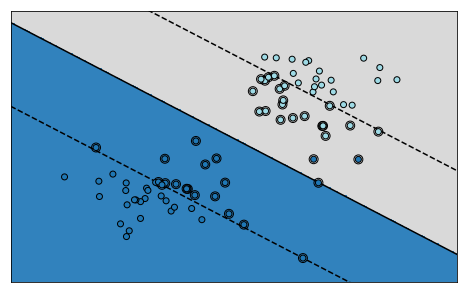

Margin with C=0.005000 is 2.811348. Misclassified points=43.181818%


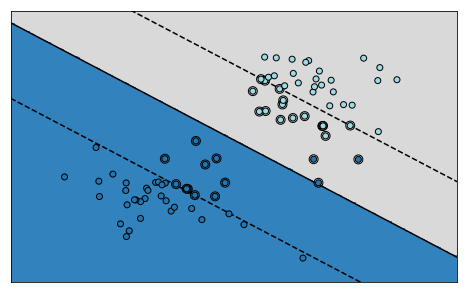

Margin with C=0.010000 is 2.526956. Misclassified points=29.545455%


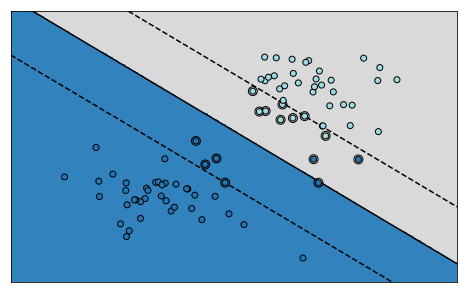

Margin with C=0.050000 is 1.796977. Misclassified points=15.909091%


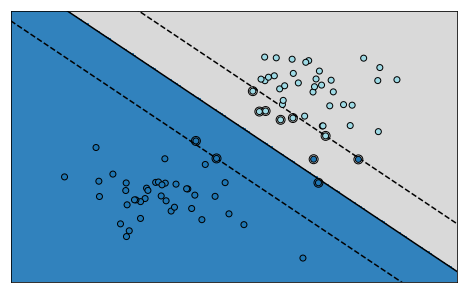

Margin with C=0.100000 is 1.418988. Misclassified points=11.363636%


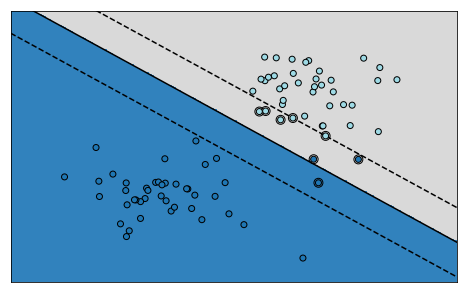

Margin with C=0.500000 is 1.139396. Misclassified points=7.954545%


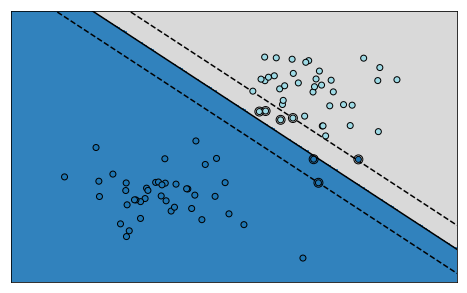

Margin with C=1.000000 is 0.723006. Misclassified points=6.818182%


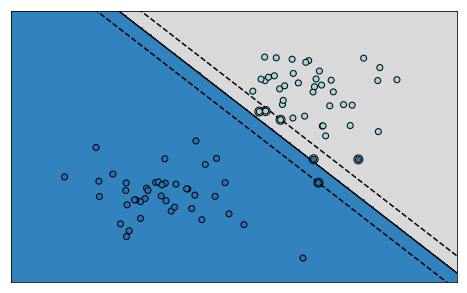

Margin with C=5.000000 is 0.466189. Misclassified points=5.681818%


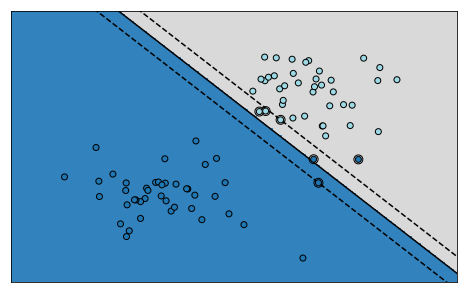

Margin with C=10.000000 is 0.458983. Misclassified points=4.545455%


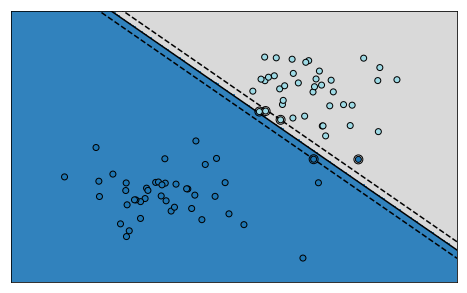

Margin with C=50.000000 is 0.241307. Misclassified points=3.409091%


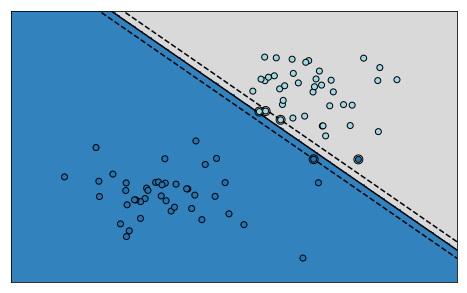

Margin with C=100.000000 is 0.241311. Misclassified points=3.409091%


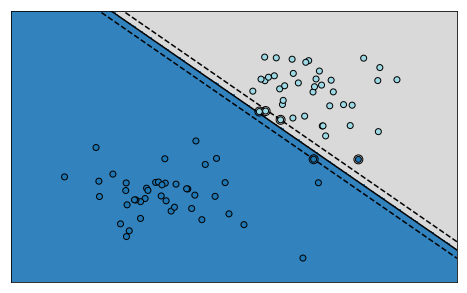

Margin with C=500.000000 is 0.241342. Misclassified points=3.409091%


In [8]:
def plot_boundary(clf , x_min = -6, x_max = 6, y_min = -6, y_max = 6):
    w = clf.coef_[0]
    b = clf.intercept_[0]
    xx = np.linspace(-6, 6)
    yy = -(w[0]/w[1])*xx - (b/w[1])
    norm_w = np.sqrt(w[0]**2+w[1]**2)
    margin = 1 / norm_w
    cos_alpha = w[1]/norm_w
    margin_y = margin/cos_alpha
    yy_down = yy - margin_y
    yy_up = yy + margin_y
    
    plt.figure(1, figsize=(8, 5))
    plt.clf()
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.tab20,edgecolors='k')

    plt.axis('tight')

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(1, figsize=(8, 5))
    plt.pcolormesh(XX, YY, Z, cmap=plt.cm.tab20c)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    plt.show()
    plt.close()
    
    return margin, norm_w

C_values = [0.00075,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0]

for C_val in C_values:
    clf = svm.SVC(kernel='linear', C=C_val)
    clf.fit(X, Y)
    margin,norm_w = plot_boundary(clf)
    distances = np.multiply(Y,clf.decision_function(X))
    numeric_tolerance = 0.001
    ignored = float(sum(distances<1.0-numeric_tolerance))/float(len(X))
    print("Margin with C=%f is %f. Misclassified points=%f%%"%(C_val,margin,ignored*100))


### 5 Regularization Effect of C

Our goal now is to numerically determine the effect of the regularization parameter $C$ in the generalization ability of the model. To this end, train the SVM with different values of $C$ and compare the training error with the prediction error of the classifier. Prepare a plot summarizing the situation and conclude.


Acc Train: 0.886364, Acc Test:0.837500
Acc Train: 0.965909, Acc Test:0.975000
Acc Train: 0.965909, Acc Test:1.000000
Acc Train: 0.954545, Acc Test:1.000000
Acc Train: 0.965909, Acc Test:1.000000
Acc Train: 0.965909, Acc Test:0.975000
Acc Train: 0.965909, Acc Test:0.975000
Acc Train: 0.977273, Acc Test:0.950000
Acc Train: 0.977273, Acc Test:0.962500
Acc Train: 0.977273, Acc Test:0.962500
Acc Train: 0.988636, Acc Test:0.937500
Acc Train: 0.988636, Acc Test:0.937500
Acc Train: 0.988636, Acc Test:0.937500


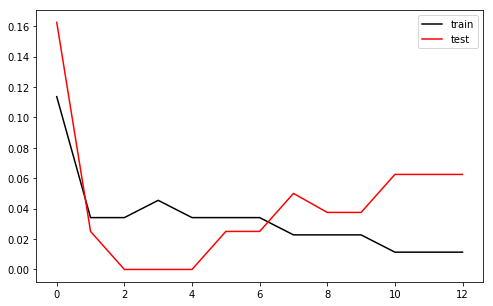

In [9]:
n_test = 40
np.random.seed(671)
X_test = np.r_[np.random.randn(n_test, 2) - [2, 2], np.random.randn(n_test, 2) + [2, 2]]
Y_test = [-1] * n_test + [1] * n_test

C_values = [0.00075,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0]
prediction_error = []
train_error = []

for C_val in C_values:
    clf = svm.SVC(kernel='linear', C=C_val)
    clf.fit(X, Y)
    score_train = clf.score(X,Y)
    score_test = clf.score(X_test,Y_test)
    train_error.append(1-score_train)
    prediction_error.append(1-score_test)
    print("Acc Train: %f, Acc Test:%f"%(score_train,score_test))
plt.figure(1, figsize=(8, 5))
plt.clf()
plt.plot(range(len(C_values)),train_error,color='k',label='train')
plt.plot(range(len(C_values)),prediction_error,color='r',label='test')
plt.legend(loc=1)
plt.show()

In practice, we cannot use the test set to determine the optimal degree of regularization (value of parameter $C$). However, we can use a validation set to anticipate the prediction error of the model. Since, in this experiment, we are simulating our data, we can easily simulate a validation set.

Acc Train: 0.886364, Acc Test:0.837500
Acc Train: 0.965909, Acc Test:0.975000
Acc Train: 0.965909, Acc Test:1.000000
Acc Train: 0.954545, Acc Test:1.000000
Acc Train: 0.965909, Acc Test:1.000000
Acc Train: 0.965909, Acc Test:0.975000
Acc Train: 0.965909, Acc Test:0.975000
Acc Train: 0.977273, Acc Test:0.950000
Acc Train: 0.977273, Acc Test:0.962500
Acc Train: 0.977273, Acc Test:0.962500
Acc Train: 0.988636, Acc Test:0.937500
Acc Train: 0.988636, Acc Test:0.937500
Acc Train: 0.988636, Acc Test:0.937500


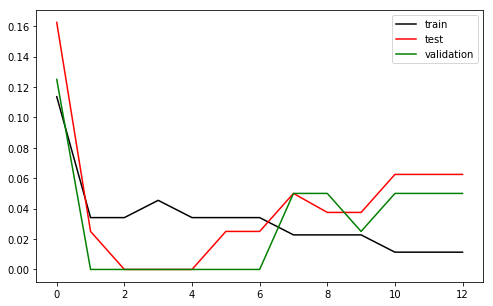

In [10]:
n_test = 40
np.random.seed(671)
X_test = np.r_[np.random.randn(n_test, 2) - [2, 2], np.random.randn(n_test, 2) + [2, 2]]
Y_test = [-1] * n_test + [1] * n_test

n_val = 20
np.random.seed(671)
X_val = np.r_[np.random.randn(n_val, 2) - [2, 2], np.random.randn(n_val, 2) + [2, 2]]
Y_val = [-1] * n_val + [1] * n_val

C_values = [0.00075,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0,500.0]
prediction_error = []
train_error = []
val_error = []

for C_val in C_values:
    clf = svm.SVC(kernel='linear', C=C_val)
    clf.fit(X, Y)
    score_train = clf.score(X,Y)
    score_test = clf.score(X_test,Y_test)
    score_val = clf.score(X_val,Y_val)
    train_error.append(1-score_train)
    prediction_error.append(1-score_test)
    val_error.append(1-score_val)
    print("Acc Train: %f, Acc Test:%f"%(score_train,score_test))
plt.figure(1, figsize=(8, 5))
plt.clf()
plt.plot(range(len(C_values)),train_error,color='k',label='train')
plt.plot(range(len(C_values)),prediction_error,color='r',label='test')
plt.plot(range(len(C_values)),val_error,color='g',label='validation')
plt.legend(loc=1)
plt.show()

### 6. Sintonization of $C$ using Cross-Validation

In practice we do not always have enough data to use a separate (and representative enough) validation set. As we have discussed, in this case we can use Kfold cross-validation.

C=0.000750, CV ERROR: 0.515278, PRED ERROR:0.162500
C=0.001000, CV ERROR: 0.268056, PRED ERROR:0.025000
C=0.005000, CV ERROR: 0.050000, PRED ERROR:0.000000
C=0.010000, CV ERROR: 0.050000, PRED ERROR:0.000000
C=0.050000, CV ERROR: 0.050000, PRED ERROR:0.000000
C=0.100000, CV ERROR: 0.050000, PRED ERROR:0.025000
C=0.500000, CV ERROR: 0.062500, PRED ERROR:0.025000
C=1.000000, CV ERROR: 0.050000, PRED ERROR:0.050000
C=5.000000, CV ERROR: 0.062500, PRED ERROR:0.037500
C=10.000000, CV ERROR: 0.062500, PRED ERROR:0.037500
C=50.000000, CV ERROR: 0.087500, PRED ERROR:0.062500
C=100.000000, CV ERROR: 0.087500, PRED ERROR:0.062500
C=500.000000, CV ERROR: 0.087500, PRED ERROR:0.062500


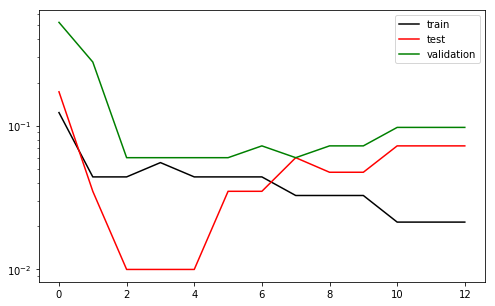

In [11]:
from sklearn.model_selection import KFold
Y=np.array(Y)
eps=0.01
prediction_error = []
train_error = []
val_error = []
for C_val in C_values:
    clf = svm.SVC(kernel='linear', C=C_val)
    kf = KFold(n_splits=10)
    acc_val = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]
        clf.fit(X_train, Y_train)
        score_val = clf.score(X_val,Y_val)
        acc_val.append(score_val)
    acc_cv = np.mean(np.array(acc_val))
    clf.fit(X, Y)
    acc_test = clf.score(X_test,Y_test)
    acc_train = clf.score(X,Y)
    print("C=%f, CV ERROR: %f, PRED ERROR:%f"%(C_val,1-acc_cv,1-acc_test))
    train_error.append(1-acc_train+eps)
    prediction_error.append(1-acc_test+eps)
    val_error.append(1-acc_cv+eps)

plt.figure(1, figsize=(8, 5))
plt.clf()
plt.plot(range(len(C_values)),train_error,color='k',label='train')
plt.plot(range(len(C_values)),prediction_error,color='r',label='test')
plt.plot(range(len(C_values)),val_error,color='g',label='validation')
plt.yscale('log')
plt.legend(loc=1)
plt.show()

## Conclusions of the Experience

Discussion.